In [ ]:
"""
# IMPORTS
# usefulls urls:
    - https://huggingface.co/datasets/sonnetechnology/license-plate-text-recognition-full
    - https://huggingface.co/microsoft/Florence-2-large
    - https://huggingface.co/qualcomm/EasyOCR
"""

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
from torchvision import transforms as T
from torch import nn
from torch.nn import functional as F
from torchvision.ops import sigmoid_focal_loss
import cv2

from unet import UNET
from functions import get_plate, enhance_plate_image

In [12]:
import os
os.environ["HIP_VISIBLE_DEVICES"] = "1" # Keep this line for good measure, it might help with some internal ROCm ops.

import torch

print(f"HIP_VISIBLE_DEVICES (from os.environ): {os.environ.get('HIP_VISIBLE_DEVICES')}")
print(torch.cuda.is_available())
print(torch.cuda.device_count())

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")

    # THIS IS THE CRUCIAL CHANGE: Explicitly select device 1
    my_device = torch.device("cuda:0")
    print(f"\nUsing explicit device: {my_device}")

else:
    my_device = torch.device("cpu")
    print("\nCUDA/ROCm not available, falling back to CPU.")

HIP_VISIBLE_DEVICES (from os.environ): 1
False
0

CUDA/ROCm not available, falling back to CPU.


In [ ]:
#  =================================== Dataset Images ===================================

In [3]:
# !pip install datasets
import datasets

ds = datasets.load_dataset("sonnetechnology/license-plate-text-recognition-full")

c:\Users\pc\Desktop\mis\unet_patent_detector\venv_unet\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Example image: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303 at 0x2E41EAA9190>


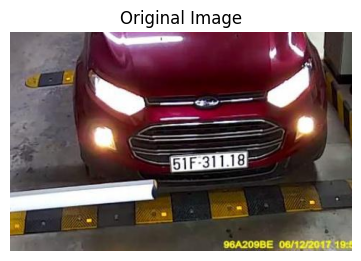

In [19]:
example = ds['train'][np.random.randint(0, len(ds['train']) - 1)]

print(f"Example image: {example['image']}")
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(example['image'])
plt.title('Original Image')
plt.axis('off')

plt.show()

In [5]:
model = UNET(channels_in=3, channels=32, num_classes=1)

In [15]:

# model.load_state_dict(torch.load('model8c_5e_ce.pt', weights_only=False,map_location='cuda:0'))
model.load_state_dict(torch.load('model16c_50e_bcelog_state_dict.pt', weights_only=False, map_location=torch.device('cpu')))

<All keys matched successfully>

In [20]:
plate, original, mask = get_plate(example['image'], model, 224, 0.75, 0.9, my_device, margin=20)


Original image dimensions: 472 x 303
Transformed image shape: (224, 224, 3)
Mask shape: (224, 224)
Mask min/max values: 0.000/0.994
Transformed bounding box - xmin: 109, xmax: 163, ymin: 126, ymax: 216
Scaling coefficients - width: 0.632, height: 0.271
Original bounding box - xmin: 109, xmax: 163, ymin: 126, ymax: 216
Final bounding box with margin - xmin: 89, xmax: 183, ymin: 106, ymax: 236
Extracted plate region shape: (131, 95, 3)


In [21]:
enhanced_plate = enhance_plate_image(plate)

In [22]:
def plot_images(original, mask, plate, enhanced_plate):
    print(f"Extracted plate shape: {plate.shape}")
    
    plt.figure(figsize=(20, 5))

    plt.subplot(141) 
    plt.imshow(original)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(142) 
    plt.imshow(mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(143)  
    plt.imshow(plate[0].permute(1, 2, 0).numpy())
    plt.title('Extracted Plate')
    plt.axis('off')

    plt.subplot(144) 
    plt.imshow(enhanced_plate, cmap='gray') 
    plt.title('Enhanced Plate')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Extracted plate shape: torch.Size([1, 3, 131, 95])


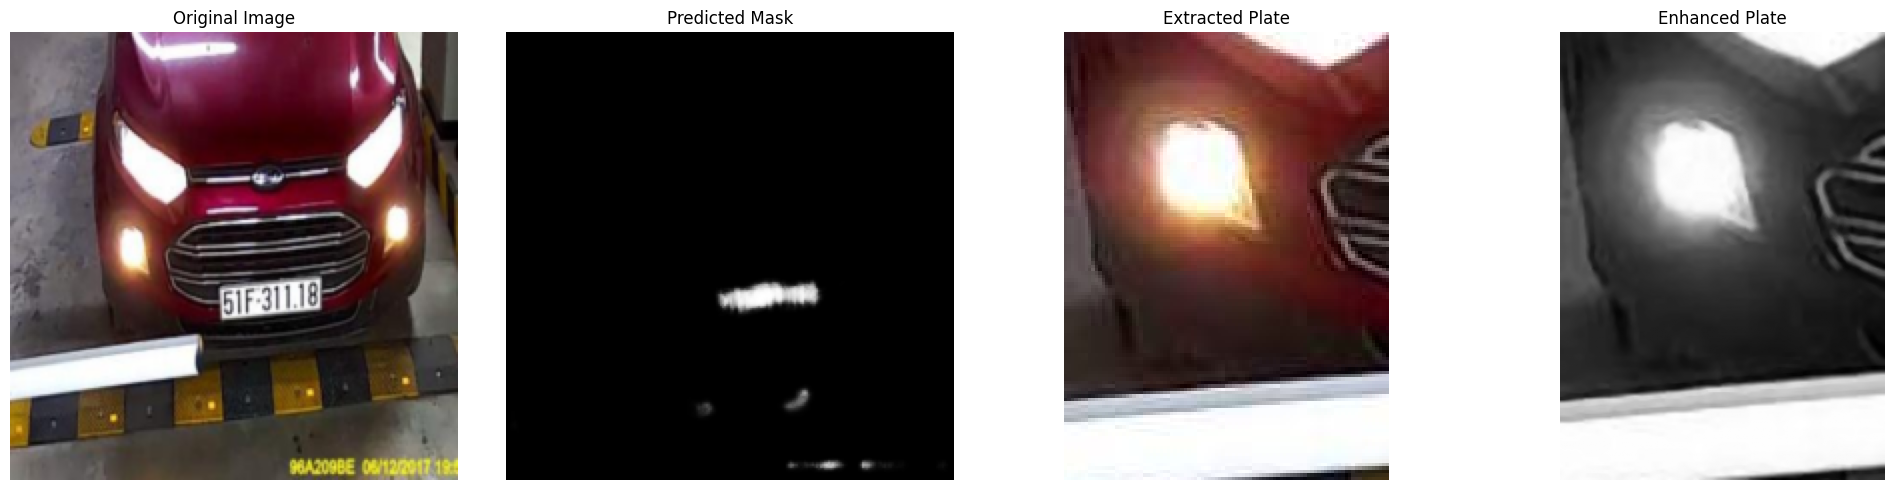

In [23]:

plot_images(original, mask, plate, enhanced_plate)

In [ ]:
#  =================================== Easy OCR ===================================

In [21]:
#  =================================== Easy OCR ===================================

# Install: pip install easyocr
import easyocr
import numpy as np
from PIL import Image

In [76]:
# Initialize EasyOCR reader
# reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())  # Use GPU if available
reader = easyocr.Reader(['en'], gpu=False)  # Use GPU if not available


Using CPU. Note: This module is much faster with a GPU.


In [94]:
def detect_plate_text(image, model, device=my_device, confidence_threshold=0.5):
    """
    Complete pipeline: Extract license plate from image and return detected text as string
    
    Args:
        image: PIL Image or image path (string)
        model: Trained UNET model
        device: torch device (cuda/cpu)
        confidence_threshold: Minimum confidence for OCR results
    
    Returns:
        str: Detected text from license plate, or empty string if no text found
    """
    try:
        print(f"type of image: {type(image)}")
        if isinstance(image, str):
            image = Image.open(image)
        
        plate, original, mask = get_plate(image, model, 224, 0.75, 0.9, device)

        enhanced_plate = enhance_plate_image(plate)
        
        if plate is None:
            return ""
        
        # plate_img = plate[0].permute(1, 2, 0).numpy()
        plate_img = enhanced_plate
        if plate_img.max() <= 1.0:
            print(f"{plate_img.max()}")
            plate_img = (plate_img * 255).astype(np.uint8)
        else:
            plate_img = plate_img.astype(np.uint8)
        
        print(f"{plate_img.shape}")
        results = reader.readtext(plate_img, detail=0)

        print(f"results: {results}")

        # detected_texts = [result[1] for result in results if result[2] > confidence_threshold]
        
        final_text = " ".join(results).strip()
        
        plot_images(original, mask, plate, enhanced_plate)

        return final_text
        
    except Exception as e:
        print(f"Error processing image: {e}")
        return ""

type of image: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Original image dimensions: 512 x 288
Transformed image shape: (224, 224, 3)
Mask shape: (224, 224)
Mask min/max values: 0.000/0.995
Transformed bounding box - xmin: 87, xmax: 130, ymin: 143, ymax: 155
Scaling coefficients - width: 2.286, height: 1.286
Original bounding box - xmin: 198, xmax: 297, ymin: 183, ymax: 199
Final bounding box with margin - xmin: 188, xmax: 307, ymin: 173, ymax: 209
Extracted plate region shape: (37, 120, 3)
0.7445008754730225
(111, 360)
results: ['123} Nc01']
Extracted plate shape: torch.Size([1, 3, 37, 120])


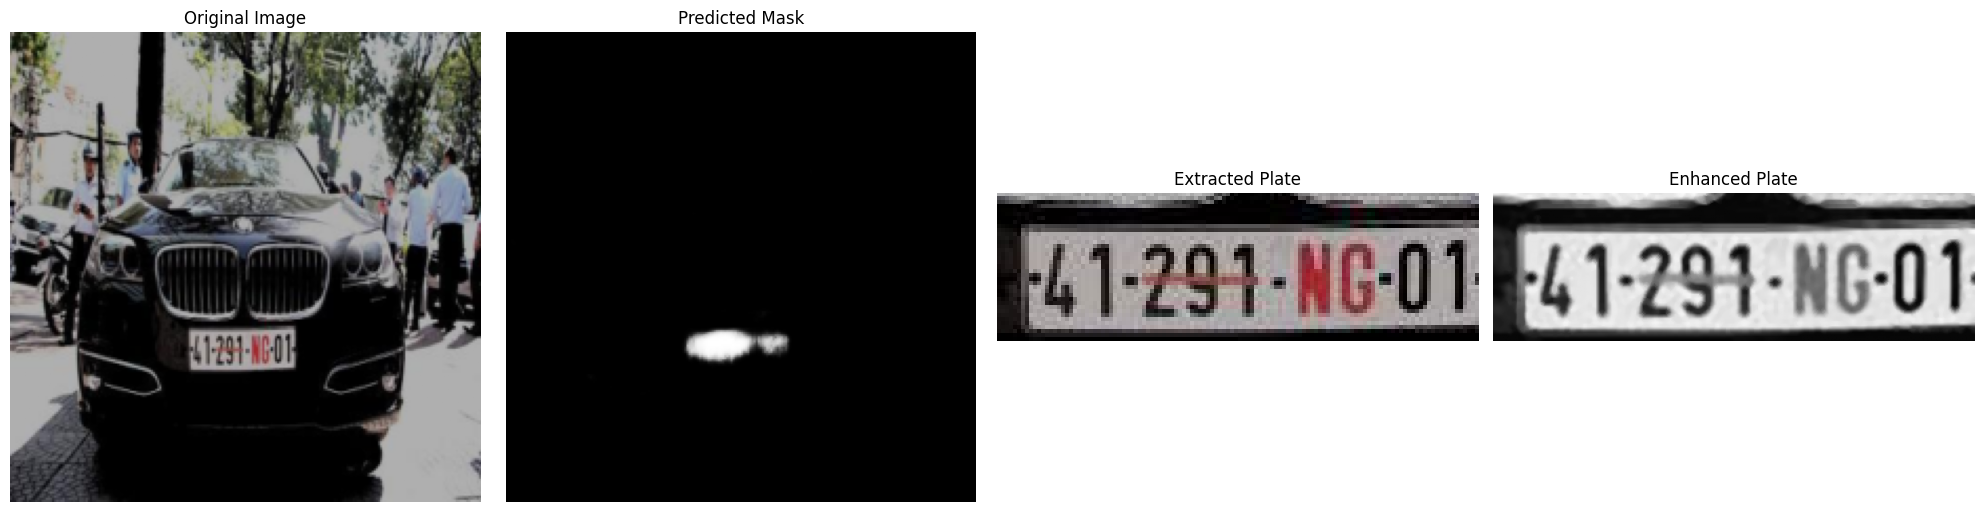

Detected text: '123} Nc01'


In [95]:

text = detect_plate_text(example['image'], model, my_device, confidence_threshold=0.1)
print(f"Detected text: '{text}'")
